In [1]:
from datasets import load_dataset
import os

import uuid
from tqdm import tqdm
import json
import math

import imgviz
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def make_entity(object_name, bbox, image_width_height,is_bbox_relative=True):
    if not is_bbox_relative:
        bbox = bbox_absolute_to_relative(bbox, image_width_height)
    entity = (object_name, (bbox[0], bbox[1], bbox[2], bbox[3]))
    return entity

In [3]:
def visualize_bbox(image, bbox_list, bbox_name_list,bbox_is_relative=True):
    assert len(bbox_list) == len(bbox_name_list), "bbox_list and bbox_name_list must have the same length"
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    if bbox_is_relative:
        # 画像のサイズを取得
        image_width_height = (image.width, image.height)
        # 相対座標を絶対座標に変換
        bbox_list = [bbox_relative_to_absolute(bbox, image_width_height) for bbox in bbox_list]
        
    #bbox_name_listをソート、bbox_listも同じ順番にソート
    bbox_name_list, bbox_list = zip(*sorted(zip(bbox_name_list, bbox_list), key=lambda x: x[0]))
    bbox_name_list = list(bbox_name_list)
    bbox_list = list(bbox_list)
    # bbox_listの座標をy1, x1, y2, x2の形式に変換
    bboxes = []
    labels = []
    label_id = -1
    old_label = None
    for bbox ,bbox_name in zip(bbox_list, bbox_name_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        if old_label != bbox_name:
            label_id += 1
            old_label = bbox_name
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    
    base_resolution = 100 * 100
    base_font_size = 3
    image_resolution = image.width * image.height
    font_size = int( base_font_size * (image_resolution / base_resolution) ** 0.5)
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=font_size,captions=bbox_name_list)

    plt.imshow(image)
    plt.show()
    
def parse_bbox(detokenizer_output: str):
    pattern = r"(((<loc\d{4}>){4}))"
    matches = re.findall(pattern, detokenizer_output)
    print("matches", matches)
    bbox_list = []
    for m in matches:
        y1, x1, y2, x2 = [int(x)/1024.0 for x in re.findall(r'\d+', m[1])]
        bbox_list.append([x1, y1, x2, y2])
    return bbox_list

def parse_bbox_and_labels(detokenizer_output: str):
    pattern = r"(((<loc\d{4}>){4})([^;<]+))"
    matches = re.findall(pattern, detokenizer_output)
    print("matches", matches)
    label_list = []
    bbox_list = []
    for m in matches:
        label_list.append(m[-1].strip())
        y1, x1, y2, x2 = [int(x)/1024.0 for x in re.findall(r'\d+', m[1])]
        bbox_list.append([x1, y1, x2, y2])
    return bbox_list, label_list
  

In [4]:
def clip_by_value(x, min_value, max_value):
    return max(min(x, max_value), min_value)

def get_loc_token(image_width_height_list, bbox_list):
    loc_bbox_list = []
    quantized_bbox_list = []
    loc_tokens = ['<loc%04d>' % i for i in range(1024)]
    for image_width_height, bbox in zip(image_width_height_list, bbox_list):
        relative_bbox = bbox_absolute_to_relative(bbox, image_width_height)
        x1 = int(round(relative_bbox[0] * 1023))
        y1 = int(round(relative_bbox[1] * 1023))
        x2 = int(round(relative_bbox[2] * 1023))
        y2 = int(round(relative_bbox[3] * 1023))
        x1 = clip_by_value(x1, 0, 1023)
        y1 = clip_by_value(y1, 0, 1023)
        x2 = clip_by_value(x2, 0, 1023)
        y2 = clip_by_value(y2, 0, 1023)
        loc_bbox_list.append(f"{loc_tokens[y1]}{loc_tokens[x1]}{loc_tokens[y2]}{loc_tokens[x2]}")
        quantized_bbox_list.append([x1, y1, x2, y2])
        
    return loc_bbox_list, quantized_bbox_list
        

In [5]:
def make_question(sentence):
    return f"<image>detect {sentence}\n"

def make_conversation(id,image_path,question,answer,gt_entities,image_w_h,ann_id,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ],
        "gt_entities": gt_entities,
        "image_width_height": image_w_h,
        "ann_id": ann_id
    }
    return return_data

In [6]:
dataset_root_dir = "/data_ssd/huggingface_dataset"
cache_dir = "/data_ssd/huggingface_cache"
image_folder_root = "/data_ssd/"
data_split = "train" #"test" #"validation" #"train"
huggingface_id = "jxu124/refcocog"
save_json_path = f"/data_ssd/refcoco_g/refcoco_g_paligemma_{data_split}.json"

dataset_id = os.path.join(dataset_root_dir,huggingface_id)

dataset = load_dataset(dataset_id, cache_dir=cache_dir, split=data_split)

In [7]:
print(dataset[0])
for key, value in dataset[0].items():
    print(f"{key}: {value}")

{'image_id': 519404, 'split': 'train', 'sentences': [{'raw': 'Two woman one in black eatting and the other has a white shirt at the desk', 'sent': 'two woman one in black eatting and the other has a white shirt at the desk', 'sent_id': 0, 'tokens': ['two', 'woman', 'one', 'in', 'black', 'eatting', 'and', 'the', 'other', 'has', 'a', 'white', 'shirt', 'at', 'the', 'desk']}, {'raw': 'Woman in white shirt looking down at laptop computer.', 'sent': 'woman in white shirt looking down at laptop computer', 'sent_id': 1, 'tokens': ['woman', 'in', 'white', 'shirt', 'looking', 'down', 'at', 'laptop', 'computer']}], 'file_name': 'COCO_train2014_000000519404_1241542.jpg', 'category_id': 1, 'ann_id': 1241542, 'sent_ids': [0, 1], 'ref_id': 5023, 'raw_anns': '{"segmentation": [[16.22, 84.86, 36.76, 52.43, 69.19, 45.95, 108.11, 50.27, 118.92, 60.0, 134.05, 76.22, 132.97, 104.32, 145.95, 128.11, 151.35, 143.24, 143.78, 164.86, 139.46, 174.59, 151.35, 191.89, 189.19, 223.24, 230.27, 265.41, 235.68, 268.6

In [8]:
id_list = []
caption_list = []
bbox_list = []
image_path_list = []
original_image_width_height_list = []
ann_id_list = []

for index, sample in enumerate(tqdm(dataset)):
    ann_id = f"refcoco_g-{index}"
    ids = sample["sent_ids"]
    id_list.extend(ids)

    raw_image_info = json.loads(sample["raw_image_info"])
    caption_list.extend( [sentences["raw"] for sentences in sample["sentences"]])
        
    image_file_name = raw_image_info["file_name"]
    original_image_width_height_list.extend([(raw_image_info["width"], raw_image_info["height"])]*len(ids))
    image_path_list.extend([os.path.join("mscoco2014/train2014",image_file_name)]*len(ids))
    bbox_list.extend([sample["bbox"]]*len(ids))
    ann_id_list.extend([ann_id]*len(ids))
    
assert len(id_list) == len(caption_list) == len(bbox_list) == len(image_path_list) == len(original_image_width_height_list)  == len(ann_id_list), "All lists must have the same length"

100%|██████████| 42226/42226 [00:07<00:00, 5784.19it/s]


In [9]:
print(f"Total number of samples: {len(id_list)}")
index = 0
print(id_list[index])
print(caption_list[index])
print(bbox_list[index])
print(image_path_list[index])
print(original_image_width_height_list[index])
print(ann_id_list[index])

Total number of samples: 80512
0
Two woman one in black eatting and the other has a white shirt at the desk
[0.0, 45.95, 238.92, 454.59]
mscoco2014/train2014/COCO_train2014_000000519404.jpg
(640, 480)
refcoco_g-0


In [10]:


loc_bbox_list,quantized_bbox_list = get_loc_token(original_image_width_height_list, bbox_list)
print(len(loc_bbox_list))
print(loc_bbox_list[index])
print(quantized_bbox_list[index])

80512
<loc0098><loc0000><loc0969><loc0382>
[0, 98, 382, 969]


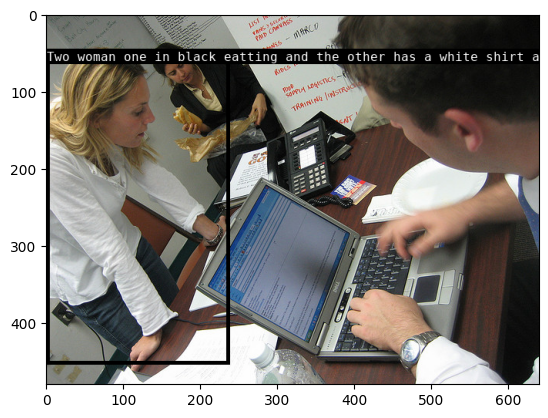

In [11]:
image_path = os.path.join(image_folder_root, image_path_list[index])
bbox = np.array(quantized_bbox_list[index]) /1023
visualize_bbox(image_path, [bbox], [caption_list[index]],bbox_is_relative=True)

matches [('<loc0098><loc0000><loc0969><loc0382>', '<loc0098><loc0000><loc0969><loc0382>', '<loc0382>')]


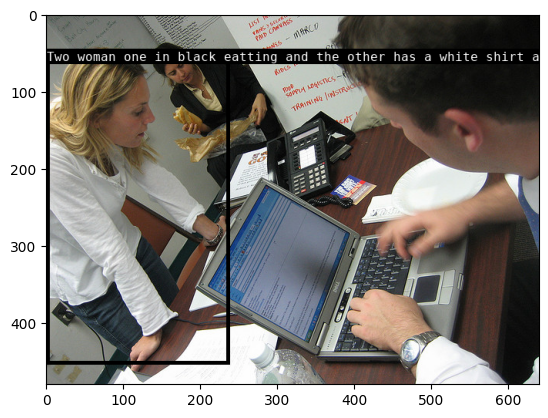

In [12]:
boxes = parse_bbox(loc_bbox_list[index])
visualize_bbox(image_path, boxes, [caption_list[index]],bbox_is_relative=True)

In [13]:
converted_data = []
for id,caption,loc_bbox, ground_bbox, image_path,original_image_width_height,ann_id in tqdm(zip(id_list,caption_list,loc_bbox_list,bbox_list,image_path_list,original_image_width_height_list,ann_id_list), total=len(id_list)):
    id = f"{huggingface_id}-{data_split}-{id}"
    question = make_question(caption)
    entity = (caption, [ground_bbox])
    conversation = make_conversation(id, image_path, question, loc_bbox, [entity],original_image_width_height,ann_id)
    converted_data.append(conversation)

  0%|          | 0/80512 [00:00<?, ?it/s]

100%|██████████| 80512/80512 [00:00<00:00, 91513.29it/s] 


id: jxu124/refcocog-train-104559
image: mscoco2014/train2014/COCO_train2014_000000573297.jpg
conversations: [{'from': 'human', 'value': '<image>detect Man wearing a red costume.\n'}, {'from': 'gpt', 'value': '<loc0107><loc0084><loc1023><loc1023>'}]
gt_entities: [('Man wearing a red costume.', [[31.71, 67.03, 384.0, 640.0]])]
image_width_height: (384, 640)
ann_id: refcoco_g-42225


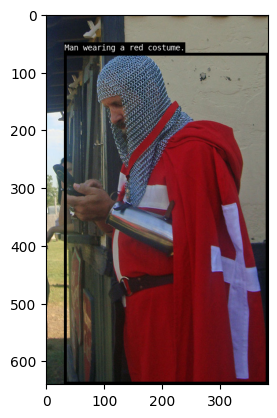

In [14]:
sample = converted_data[-1]
for key, value in sample.items():
    print(f"{key}: {value}")
image_path = os.path.join(image_folder_root, sample["image"])
visualize_bbox(image_path, [sample["gt_entities"][0][1][0]], [sample["gt_entities"][0][0]],bbox_is_relative=False)

matches [('<loc0107><loc0084><loc1023><loc1023>', '<loc0107><loc0084><loc1023><loc1023>', '<loc1023>')]


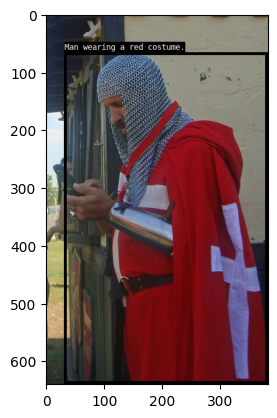

In [15]:
parsed_bbox_list = parse_bbox(sample["conversations"][1]["value"])
visualize_bbox(image_path, parsed_bbox_list, [sample["gt_entities"][0][0]],bbox_is_relative=True)

In [16]:
if not os.path.exists(os.path.dirname(save_json_path)):
    os.makedirs(os.path.dirname(save_json_path))
with open(save_json_path, "w") as f:
    json.dump(converted_data, f, indent=4, ensure_ascii=False)

In [17]:
with open(save_json_path, "r") as f:
    loaded_data = json.load(f)
print("len(loaded_data):",len(loaded_data))

len(loaded_data): 80512


In [18]:
image_folder_root = "/data_ssd"

exist_image_count = 0
for i in tqdm(range(len(loaded_data))):
    image_file_name = loaded_data[i]["image"]
    image_path = os.path.join(image_folder_root,image_file_name)
    if not os.path.exists(image_path):
        print(f"Image file does not exist: {image_path}")
        continue
    exist_image_count += 1
print("exist_image_count:", exist_image_count)
print("non_exist_image_count:", len(loaded_data) - exist_image_count)
print("exist_image_count / len(loaded_data):", exist_image_count / len(loaded_data))

100%|██████████| 80512/80512 [00:03<00:00, 26210.54it/s]

exist_image_count: 80512
non_exist_image_count: 0
exist_image_count / len(loaded_data): 1.0
